In [9]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
from mplsoccer import VerticalPitch, FontManager
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [10]:
import matplotlib.font_manager as font_manager
font_path_regular = '/Users/alfonsomarino/Desktop/Teko/static/Teko-Regular.ttf'
# Create a font properties object with the font file
font_normal = font_manager.FontProperties(fname=font_path_regular)

font_path_med = "/Users/alfonsomarino/Desktop/Teko/static/Teko-Medium.ttf"
font_med = font_manager.FontProperties(fname = font_path_med)

font_path_semi = "/Users/alfonsomarino/Desktop/Teko/static/Teko-SemiBold.ttf"
font_semi = font_manager.FontProperties(fname = font_path_semi)

In [11]:
list_html = [
    '/Users/alfonsomarino/Desktop/Progetti/Campionato/Pass_Assist/data/Lazio 2-2 AC Milan - Serie A 2024:2025 - Live.html',
    '/Users/alfonsomarino/Desktop/Progetti/Campionato/Pass_Assist/data/Lazio 3-0 Genoa - Serie A 2024:2025 - Live.html',
    '/Users/alfonsomarino/Desktop/Progetti/Campionato/Pass_Assist/data/Como 1-5 Lazio - Serie A 2024:2025 - Live.html',
    '/Users/alfonsomarino/Desktop/Progetti/Campionato/Pass_Assist/data/Juventus 1-0 Lazio - Serie A 2024:2025 - Live.html',
    '/Users/alfonsomarino/Desktop/Progetti/Campionato/Pass_Assist/data/Lazio 2-1 Empoli - Serie A 2024:2025 - Live.html',
    '/Users/alfonsomarino/Desktop/Progetti/Campionato/Pass_Assist/data/Torino 2-3 Lazio - Serie A 2024:2025 - Live.html',
    '/Users/alfonsomarino/Desktop/Progetti/Campionato/Pass_Assist/data/Fiorentina 2-1 Lazio - Serie A 2024:2025 - Live.html',
    '/Users/alfonsomarino/Desktop/Progetti/Campionato/Pass_Assist/data/Lazio 2-1 Verona - Serie A 2024:2025 - Live.html'
    
]

In [12]:
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r')
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

In [13]:
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict

In [14]:
def extract_event_data(event):
    event_data = {
        "Player ID" : event.get("playerId", None),
        'Event Type': event['type']['displayName'],
        'Event Value': event['type']['value'],
        'Outcome': event['outcomeType']['displayName'],
        "Minuto" : event["minute"],
        'Start X': event['x'],
        'Start Y': event['y'],
        'End X': event.get('endX', None),  
        'End Y': event.get('endY', None)  
    }

    # Managing qualifiers, creating dynamic columns for each displayName
    qualifier_columns = {}
    for qualifier in event.get('qualifiers', []):
        q_display_name = qualifier['type']['displayName']
        q_value = qualifier.get('value', None)
        
        # If there is no value, we create a column with ‘Yes’ or ‘No’.
        if q_value is None:
            qualifier_columns[q_display_name] = "Yes"
        else:
            # If the name already exists, add a numeric suffix
            if q_display_name in qualifier_columns:
                i = 1
                while f"{q_display_name}_{i}" in qualifier_columns:
                    i += 1
                q_display_name = f"{q_display_name}_{i}"
            
            qualifier_columns[q_display_name] = q_value
    
    # Add qualifiers to the event
    event_data.update(qualifier_columns)
    
    return event_data

In [15]:
def create_events_dict(path):
    json_data_txt = extract_json_from_html(path)
    data = json.loads(json_data_txt)
    events_dict = extract_data_from_dict(data)
    # Creation of the initial DataFrame
    event_data = [extract_event_data(event) for event in events_dict]
    df = pd.DataFrame(event_data)

    # Find all possible qualifiers
    all_qualifiers = set()
    for event in events_dict:
        for qualifier in event.get('qualifiers', []):
            all_qualifiers.add(qualifier['type']['displayName'])

    # Add missing columns with null values or ‘No’ if it is an indicator
    for qualifier in all_qualifiers:
        if qualifier not in df.columns:
            if df[qualifier].dtype == object:  # Se il qualificatore è "Yes/No"
                df[qualifier] = "No"
            else:
                df[qualifier] = None

    #df = df[df["Player ID"]== player_id]
    df = df[df["Start X"] >= 50]

    return df

In [16]:
# Initialise a list to store DataFrames
all_dataframes = []

# Itera through HTML file paths
for path in list_html:
    pisilli_data = create_events_dict(path)
    all_dataframes.append(pisilli_data)

# Concatenate all DataFrames into one
final_dataframe = pd.concat(all_dataframes, ignore_index=True)

In [17]:
# Initialise the ‘Assist Player’ column with NaN
final_dataframe['Assist Player'] = None

# Variable to keep track of the last assistant
last_assist_player = None

for index, row in final_dataframe.iterrows():
    # If the event is a ‘Pass’ with ‘Outcome Success’, update the last assistant
    if row['Event Type'] == 'Pass' and row['Outcome'] == 'Successful':
        last_assist_player = row['Player ID']
    # If the event is a ‘Goal’, assign the last assistant
    elif row['Event Type'] == 'Goal':
        final_dataframe.at[index, 'Assist Player'] = last_assist_player

/var/folders/1q/90p05g051_l43jfjx7s90z1h0000gn/T/ipykernel_1263/2175745129.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_dataframe['Assist Player'] = None


In [18]:
# Initialise the ‘Goal Assisted’ column with ‘No’.
final_dataframe['Goal Assisted'] = 'No'

# Variable to keep track of the last assistant
last_assist_player = None


for index, row in final_dataframe.iterrows():
    # If the event is a ‘Pass’ with ‘Outcome Success’, update the last assistant
    if row['Event Type'] == 'Pass' and row['Outcome'] == 'Successful':
        last_assist_player = row['Player ID']
    # If the event is a ‘Goal’, update ‘Goal Assisted’ for the previous step
    elif row['Event Type'] == 'Goal':
        # Check the last successful passage
        if last_assist_player is not None:
            # Find the index of the passage that gave assists
            for i in range(index-1, -1, -1):
                if final_dataframe.at[i, 'Event Type'] == 'Pass' and final_dataframe.at[i, 'Outcome'] == 'Successful':
                    final_dataframe.at[i, 'Goal Assisted'] = 'Yes'
                    break

/var/folders/1q/90p05g051_l43jfjx7s90z1h0000gn/T/ipykernel_1263/3337726332.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_dataframe['Goal Assisted'] = 'No'


In [19]:
pd.options.display.max_columns = None
final_dataframe[final_dataframe["Event Type"] == "Goal"]

,Player ID,Event Type,Event Value,Outcome,Minuto,Start X,Start Y,End X,End Y,StandingSave,Angle,PassEndY,Zone,Length,PassEndX,Longball,OppositeRelatedEvent,Defensive,Offensive,Head,ThrowIn,Chipped,Foul,FreekickTaken,HeadPass,IntentionalAssist,ShotAssist,BigChanceCreated,KeyPass,BlockedY,LowRight,BigChance,GoalMouthY,GoalMouthZ,RelatedEventId,Assisted,RightFoot,RegularPlay,SixYardBlock,BlockedX,FirstTouch,BoxCentre,SavedOffline,Blocked,OutfielderBlock,LastMan,OtherBodyPart,LeftFoot,Cross,BlockedCross,MissLeft,CornerTaken,FromCorner,IntentionalGoalAssist,LeadingToGoal,SmallBoxCentre,HighCentre,MissRight,BoxRight,ParriedDanger,Hands,KeeperSaveInTheBox,Volley,GoalKick,LayOff,Yellow,PlayerCaughtOffside,IndirectFreekickTaken,OutOfBoxCentre,IndividualPlay,HighRight,DirectFreekick,JerseyNumber,PlayerPosition,FormationSlot,KeeperThrow,Throughball,DivingSave,LowCentre,LowLeft,InvolvedPlayers,TeamFormation,CaptainPlayerId,TeamPlayerFormation,SmallBoxLeft,Feet,KeeperSaveInSixYard,MissHigh,ParriedSafe,HighLeft,Collected,BoxLeft,KeeperSaveObox,HighClaim,OverRun,FastBreak,LeadingToAttempt,ThrowinSetPiece,Penalty,KeeperMissed,DeepBoxLeft,AerialFoul,VoidYellowCard,SecondYellow,OneOnOne,SetPiece,Red,OwnGoal,KeeperSaved,Assist Player,Goal Assisted
48,383864.0,Goal,16,Successful,7,95.9,51.8,NaN,NaN,NaN,NaN,NaN,Center,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Yes,48.6,22.2,69,Yes,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,302692.0,No
353,361406.0,Goal,16,Successful,61,92.3,47.9,NaN,NaN,Yes,NaN,NaN,Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Yes,51.9,18.4,513,Yes,Yes,Yes,NaN,NaN,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,379790.0,No
374,365122.0,Goal,16,Successful,65,97.2,47.5,NaN,NaN,Yes,NaN,NaN,Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Yes,48.7,2.5,532,Yes,Yes,Yes,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,379790.0,No
387,349207.0,Goal,16,Successful,71,89.3,43.5,NaN,NaN,Yes,NaN,NaN,Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,48.9,4.4,679,Yes,Yes,Yes,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,317506.0,No
648,423863.0,Goal,16,Successful,20,89.9,63.0,NaN,NaN,Yes,NaN,NaN,Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,46.2,2.5,301,Yes,Yes,Yes,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275698.0,No
1036,44055.0,Goal,16,Successful,85,95.1,49.7,NaN,NaN,Yes,NaN,NaN,Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,53.3,3.8,NaN,NaN,Yes,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Na

In [20]:
pass_df = final_dataframe[(final_dataframe["Event Type"] == "Pass") & (final_dataframe["Player ID"] == 379790.0) & (final_dataframe["Start Y"] < 100)]

In [21]:
assist_df = pass_df[pass_df["Goal Assisted"] == "Yes"]

In [22]:
assist_df

,Player ID,Event Type,Event Value,Outcome,Minuto,Start X,Start Y,End X,End Y,StandingSave,Angle,PassEndY,Zone,Length,PassEndX,Longball,OppositeRelatedEvent,Defensive,Offensive,Head,ThrowIn,Chipped,Foul,FreekickTaken,HeadPass,IntentionalAssist,ShotAssist,BigChanceCreated,KeyPass,BlockedY,LowRight,BigChance,GoalMouthY,GoalMouthZ,RelatedEventId,Assisted,RightFoot,RegularPlay,SixYardBlock,BlockedX,FirstTouch,BoxCentre,SavedOffline,Blocked,OutfielderBlock,LastMan,OtherBodyPart,LeftFoot,Cross,BlockedCross,MissLeft,CornerTaken,FromCorner,IntentionalGoalAssist,LeadingToGoal,SmallBoxCentre,HighCentre,MissRight,BoxRight,ParriedDanger,Hands,KeeperSaveInTheBox,Volley,GoalKick,LayOff,Yellow,PlayerCaughtOffside,IndirectFreekickTaken,OutOfBoxCentre,IndividualPlay,HighRight,DirectFreekick,JerseyNumber,PlayerPosition,FormationSlot,KeeperThrow,Throughball,DivingSave,LowCentre,LowLeft,InvolvedPlayers,TeamFormation,CaptainPlayerId,TeamPlayerFormation,SmallBoxLeft,Feet,KeeperSaveInSixYard,MissHigh,ParriedSafe,HighLeft,Collected,BoxLeft,KeeperSaveObox,HighClaim,OverRun,FastBreak,LeadingToAttempt,ThrowinSetPiece,Penalty,KeeperMissed,DeepBoxLeft,AerialFoul,VoidYellowCard,SecondYellow,OneOnOne,SetPiece,Red,OwnGoal,KeeperSaved,Assist Player,Goal Assisted
352,379790.0,Pass,1,Successful,61,87.3,70.7,92.3,47.7,Yes,5.04,47.7,Center,16.5,92.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,16,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Yes
373,379790.0,Pass,1,Successful,65,97.6,66.7,96.3,49.1,Yes,4.60,49.1,Center,12.0,96.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,16,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Yes
1108,379790.0,Pass,1,Successful,93,98.2,87.2,92.4,49.0,Yes,4.48,49.0,Center,26.7,92.4,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,Yes,16,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,NaN,NaN,NaN,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Yes
1305,379790.0,Pass,1,Successful,30,82.9,91.2,87.0,61.7,Yes,4.92,61.7,Center,20.5,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,16,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Yes
2650,379790.0,Pass,1,Successful,48,95.2,79.8,89.7,54.8,Yes,4.38,54.8,Center,18.0,89.7,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,Yes,16,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Yes
3008,379790.0,Pass,1,Successful,7,92.8,73.8,85.4,53.2,Yes,4.21,53.2,Center,16.0,85.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,16,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [23]:
pass_df

,Player ID,Event Type,Event Value,Outcome,Minuto,Start X,Start Y,End X,End Y,StandingSave,Angle,PassEndY,Zone,Length,PassEndX,Longball,OppositeRelatedEvent,Defensive,Offensive,Head,ThrowIn,Chipped,Foul,FreekickTaken,HeadPass,IntentionalAssist,ShotAssist,BigChanceCreated,KeyPass,BlockedY,LowRight,BigChance,GoalMouthY,GoalMouthZ,RelatedEventId,Assisted,RightFoot,RegularPlay,SixYardBlock,BlockedX,FirstTouch,BoxCentre,SavedOffline,Blocked,OutfielderBlock,LastMan,OtherBodyPart,LeftFoot,Cross,BlockedCross,MissLeft,CornerTaken,FromCorner,IntentionalGoalAssist,LeadingToGoal,SmallBoxCentre,HighCentre,MissRight,BoxRight,ParriedDanger,Hands,KeeperSaveInTheBox,Volley,GoalKick,LayOff,Yellow,PlayerCaughtOffside,IndirectFreekickTaken,OutOfBoxCentre,IndividualPlay,HighRight,DirectFreekick,JerseyNumber,PlayerPosition,FormationSlot,KeeperThrow,Throughball,DivingSave,LowCentre,LowLeft,InvolvedPlayers,TeamFormation,CaptainPlayerId,TeamPlayerFormation,SmallBoxLeft,Feet,KeeperSaveInSixYard,MissHigh,ParriedSafe,HighLeft,Collected,BoxLeft,KeeperSaveObox,HighClaim,OverRun,FastBreak,LeadingToAttempt,ThrowinSetPiece,Penalty,KeeperMissed,DeepBoxLeft,AerialFoul,VoidYellowCard,SecondYellow,OneOnOne,SetPiece,Red,OwnGoal,KeeperSaved,Assist Player,Goal Assisted
16,379790.0,Pass,1,Successful,1,60.5,95.5,71.4,65.4,Yes,5.22,65.4,Center,23.5,71.4,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,No
28,379790.0,Pass,1,Successful,3,61.3,94.0,53.1,77.5,Yes,4.06,77.5,Center,14.1,53.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,No
64,379790.0,Pass,1,Successful,10,66.2,82.8,72.4,61.5,Yes,5.13,61.5,Center,15.9,72.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,No
70,379790.0,Pass,1,Successful,10,59.5,64.8,71.7,85.9,Yes,0.84,85.9,Left,19.2,71.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,No
72,379790.0,Pass,1,Successful,10,75.8,80.3,94.3,34.0,Yes,5.27,34.0,Center,37.0,94.3,Yes,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,Yes,15,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

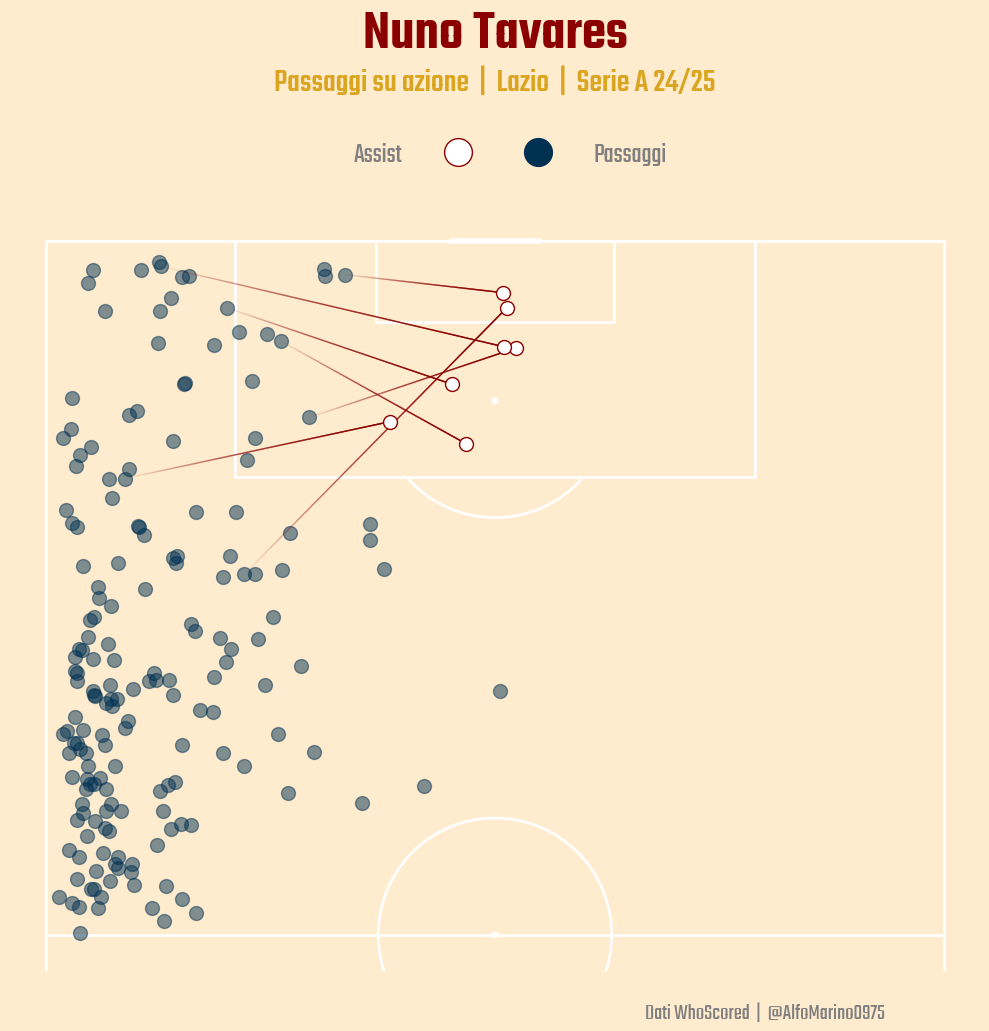

In [30]:
pitch = VerticalPitch(pitch_type='opta', pitch_color='blanchedalmond', line_color='white',line_alpha=1, half = True)
fig, ax = pitch.draw(figsize=(10, 14), constrained_layout=False, tight_layout=True)
fig.set_facecolor('blanchedalmond')

pitch.scatter(pass_df["Start X"], pass_df["Start Y"], s= 100, ax = ax, c= "#003153", alpha=.5, marker = "o")
pitch.lines(assist_df["Start X"], assist_df["Start Y"],
                  assist_df["End X"], assist_df["End Y"],
                  lw=1, transparent=True, comet=True, label='Assist',
                  color='darkred', ax=ax)
pitch.scatter(assist_df["End X"], assist_df["End Y"], s=100, ax=ax, c="white", edgecolor="darkred", linewidth=1, alpha=1, marker="o", zorder = 2)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markeredgecolor = "darkred", markersize=20, linewidth=0),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#003153',markeredgecolor = "#003153", markersize=20, linewidth=0)]

ax.legend(handles=legend_elements, loc='upper center', frameon=False, fontsize='large', ncol=2, bbox_to_anchor=(0.51, 1.1))

ax.text(
    x=35, 
    y=105.8, 
    s='Passaggi', 
    fontsize=20, 
    fontproperties=font_normal,  
    color='grey', 
    ha='center'
)

ax.text(
    x=63, 
    y=105.8, 
    s='Assist', 
    fontsize=20, 
    fontproperties=font_normal,  
    color='grey', 
    ha='center'
)



ax.text(
    x=50, 
    y=114, 
    s='Nuno Tavares', 
    fontsize=40, 
    fontproperties=font_semi,  
    color='darkred', 
    ha='center'
)

ax.text(
    x=50, 
    y=110.9, 
    s='Passaggi su azione  |  Lazio  |  Serie A 24/25', 
    fontsize=23, 
    fontproperties=font_med,  
    color='goldenrod', 
    ha='center'
)

ax.text(
    x=20, 
    y=44, 
    s= "Dati WhoScored  |  @AlfoMarino0975", 
    fontsize=16, 
    fontproperties=font_normal,  
    color='grey', 
    ha='center'
)

output_path = "/Users/alfonsomarino/Desktop/pitch_nuno.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
